In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

import warnings
warnings.simplefilter("ignore")


from pymc3 import Model, Normal, HalfNormal, SkewNormal
from pymc3 import find_MAP
from pymc3 import NUTS, sample
from scipy import optimize
from pymc3 import traceplot
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
abatement_historical = pd.read_csv('./Data/abatement_calculations.csv')

In [3]:
abatement_historical.set_index('country', inplace=True)
abatement_historical = abatement_historical

In [4]:
#creating subsets based on labels
regression_1 = abatement_historical[abatement_historical.label==1]
regression_2 = abatement_historical[abatement_historical.label==2]
regression_3 = abatement_historical.loc[(abatement_historical.label==0)
                                         |(abatement_historical.label==3)
                                        |(abatement_historical.label==4)]
regression_4 = abatement_historical[abatement_historical.label==5]

In [5]:
#In order to avoid errors I have to remove Saudia Arabia and UAE from our cohort.
#They have a steady history of 0 abatement, so they won't be able to work within the bayesian regression, and will affect results of the traditional regressions
regression_1.drop(['Saudi Arabia', 'United Arab Emirates', 'Kuwait'], axis=0, inplace=True)

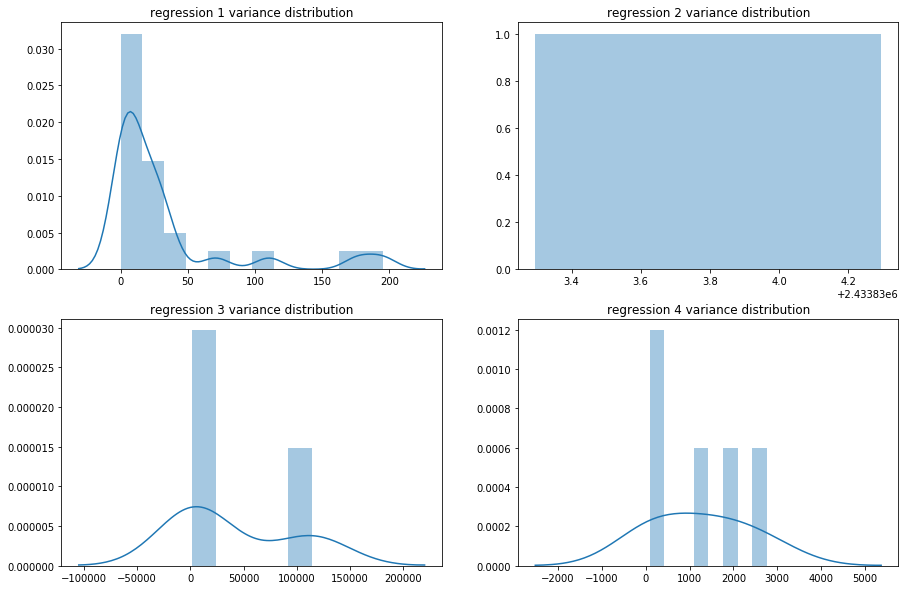

In [6]:
#checking out the distributions of each grouping
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.distplot(regression_1.drop('label', axis=1).T.var());
plt.title('regression 1 variance distribution');

plt.subplot(2,2,2)
sns.distplot(regression_2.drop('label', axis=1).T.var());
plt.title('regression 2 variance distribution');

plt.subplot(2,2,3)
sns.distplot(regression_3.drop('label', axis=1).T.var(), bins=5);
plt.title('regression 3 variance distribution');

plt.subplot(2,2,4)
sns.distplot(regression_4.drop('label', axis=1).T.var(), bins=8);
plt.title('regression 4 variance distribution');

## Bayesian Regression Development
<a id='bayesian_development'></a>

This process was adapted from a notebook developd by Phillippa Thomson

$$y_{t} = \beta_0 + \sum_{i=1}^{t}\beta_i y_{t-i} +  \sum_{i=1}^{N}\beta_j x_{ji} + \epsilon_i$$ 

   
$$\beta_0 \sim Skew Normal(1.75, 1)$$

$$\beta_1 \sim Skew Normal(1.75, 1)$$

$$\epsilon \sim Half Normal(1, 0)$$


## Bayesian Regression for Cohort 1
<a id='bayesian'></a>


RUN THIS CELL AT YOUR OWN RISK (long print out and takes forever)

In [ ]:
#building lagged dataframe and running it through a regression
train_yi = []
train_preds = []

test_yi = []
test_preds = []

for i in regression_1.index:
    dataset = pd.DataFrame()
    dataset['target'] = regression_1[regression_1.index==i].T.iloc[:,0]
    for n in range(1, 16):
        dataset[f'lag{n}'] = dataset['target'].shift(n)
    dataset = dataset.loc['2005':]
    train = dataset[0:-2]
    test = dataset[-2:-1]
    
    #setting up train, val, test
    train_target = train['target']
    for y in train_target:
        train_yi.append(y)
    test_target = test['target']
    for h in test_target:
        test_yi.append(h)

    #setting up x and y for MCMC
    y = np.array(train_target).reshape(-1,1)
    X = train.drop('target', axis=1)
    ss = StandardScaler()
    X = ss.fit_transform(X)

    #setting standard deviation to feed into the mcmc model
    mcmc_std = train_target.std()
    
    #Building model
    basic_model = Model()
    with basic_model:
        # start by defining distribution for all parameters
        # use sd to determine strength of the prior
        # big sd is a weak prior
        intercept = Normal('intercept', mu=0, sd=mcmc_std)
        # the shape on beta is the number of features in the fit
        beta = Normal('beta', mu=0, sd=mcmc_std, shape=15)
        # sigma is the width of the gaussian around yhat
        # (i.e. related to the size of the residuals)
        sigma = HalfNormal('sigma', sd=1)

        # create a formula for yhat
        y_hat = intercept + beta * X

        # simulate data as a distribution around yhat
        Y_obs = Normal('Y_obs', mu=y_hat, sd=sigma, observed=y)

        map_estimate = find_MAP(model=basic_model)
    with basic_model:
        trace = sample(2000,cores=1) #set to sample twice so your predictions can be compared
        
    #takes in inputs (X) and generates an entire range of 2000 predictions (y_hat)
    preds_train = []
    for i in trace:
        sigma = i['sigma']
        eps = np.random.normal(0, sigma)
        y_hat = i['intercept'] + np.matmul(X, i['beta']) + eps
        preds_train.append(y_hat)

    #generating predictions for the train dataset
    avg_preds_train = []
    for i in pd.DataFrame(preds_train):
        avg_preds_train.append(np.mean(preds_train[i]))
    
    #setting x and y for test predictions
    y_test = np.array(test_target).reshape(-1,1)
    X_test = np.array(test.drop('target', axis=1))
    ss_test = StandardScaler()
    X_test = ss.fit_transform(X_test)
    
     #generating predictions for the test set
    preds_test = []
    for i in trace:
        sigma = i['sigma']
        eps = np.random.normal(0, sigma)
        y_hat = i['intercept'] + np.matmul(X_test, i['beta']) + eps
        preds_test.append(y_hat)
    avg_preds_test = []
    for i in pd.DataFrame(preds_test):
        avg_preds_test.append(np.mean(preds_test[i]))   
    train_preds.append([p for p in avg_preds_train])
    test_preds.append([q for q in avg_preds_test])

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '51272' (I am process '52292')
logp = 100.64, ||grad|| = 11.61: 100%|██████████| 17/17 [00:00<00:00, 1042.05it/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, beta, intercept]
100%|██████████| 2500/2500 [00:04<00:00, 553.21it/s]
logp = -431.44, ||grad|| = 0.98678: 100%|██████████| 35/35 [00:00<00:00, 1302.63it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, beta, intercept]
100%|██████████| 2500/2500 [00:05<00:00, 463.78it/s]
logp = -415.88, ||grad|| = 0.0015831: 100%|██████████| 33/33 [00:00<00:00, 1291.23it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, beta, intercept]
100%|██████████| 2500/2500 [00:06<00:00, 379.57it/s]
logp = -124.39

In [ ]:
#building lagged dataframe and running it through a regression
train_yi = []
train_preds = []

test_yi = []
test_preds = []

for i in regression_1.index:
    dataset = pd.DataFrame()
    dataset['target'] = regression_1[regression_1.index==i].T.iloc[:,0]
    for n in range(1, 16):
        dataset[f'lag{n}'] = dataset['target'].shift(n)
    dataset = dataset.loc['2005':]
    train = dataset[0:-2]
    test = dataset[-2:-1]
    
    #setting up train, val, test
    train_target = train['target']
    for y in train_target:
        train_yi.append(y)
    test_target = test['target']
    for h in test_target:
        test_yi.append(h)

    #setting up x and y for MCMC
    y = np.array(train_target).reshape(-1,1)
    X = train.drop('target', axis=1)
    ss = StandardScaler()
    X = ss.fit_transform(X)

    #setting standard deviation to feed into the mcmc model
    mcmc_std = train_target.std()
    
    #Building model
    basic_model = Model()
    with basic_model:
        # start by defining distribution for all parameters
        # use sd to determine strength of the prior
        # big sd is a weak prior
        intercept = Normal('intercept', mu=0, sd=mcmc_std)
        # the shape on beta is the number of features in the fit
        beta = Normal('beta', mu=0, sd=mcmc_std, shape=15)
        # sigma is the width of the gaussian around yhat
        # (i.e. related to the size of the residuals)
        sigma = HalfNormal('sigma', sd=1)

        # create a formula for yhat
        y_hat = intercept + beta * X

        # simulate data as a distribution around yhat
        Y_obs = Normal('Y_obs', mu=y_hat, sd=sigma, observed=y)

        map_estimate = find_MAP(model=basic_model)
    with basic_model:
        trace = sample(2000,cores=1) #set to sample twice so your predictions can be compared
        
    #takes in inputs (X) and generates an entire range of 2000 predictions (y_hat)
    preds_train = []
    for i in trace:
        sigma = i['sigma']
        eps = np.random.normal(0, sigma)
        y_hat = i['intercept'] + np.matmul(X, i['beta']) + eps
        preds_train.append(y_hat)

    #generating predictions for the train dataset
    avg_preds_train = []
    for i in pd.DataFrame(preds_train):
        avg_preds_train.append(np.mean(preds_train[i]))
    
    #setting x and y for test predictions
    y_test = np.array(test_target).reshape(-1,1)
    X_test = np.array(test.drop('target', axis=1))
    ss_test = StandardScaler()
    X_test = ss.fit_transform(X_test)
    
     #generating predictions for the test set
    preds_test = []
    for i in trace:
        sigma = i['sigma']
        eps = np.random.normal(0, sigma)
        y_hat = i['intercept'] + np.matmul(X_test, i['beta']) + eps
        preds_test.append(y_hat)
    avg_preds_test = []
    for i in pd.DataFrame(preds_test):
        avg_preds_test.append(np.mean(preds_test[i]))   
    train_preds.append([p for p in avg_preds_train])
    test_preds.append([q for q in avg_preds_test])

In [ ]:
train_predictions

In [ ]:
train_predictions = []
for i in train_preds:
    for n in i:
        train_predictions.append(n)
        
test_predictions = []
for i in test_preds:
    for n in i:
        test_predictions.append(n)

In [ ]:
print(f'|1|Bayesian autoregression|{np.round(r2_score(train_yi, train_predictions), 2)}|{np.round(r2_score(test_yi, test_predictions), 2)}\
|{np.round(mean_squared_error(train_yi, train_predictions), 2)}|{np.round(mean_squared_error(test_yi, test_predictions), 2)}|')

- build a dataframe where features are lagged timepoints
- target is the next feature in the progression  
  
- specify priors on all coefficients
- specify priors on variance of data
- plug things into the model 
- follow pymc3 lesson

- goal is actually a posterior predictive
- pyflux provides uncertainty bounds (UL + LL)
- for a highly generalized bayesian regression try pymc3
    - you  need to specify priors and distributions
    - begin with something relatively uninformative (broad gaussian, uniform, etc.) 
    
1. write out an equation, which model inteded (ex. regression + variance)
2. specify priors for each coefficient, prior on variance
    - pymc3 this means creating new objects 
3. take existing objects/variables that contain priors and build a likelihood distribution with observed data
    - prior variables act as parameters
    - MCMC
4. estimate y-hat and save values
    - this is where we capture variance
    - write out a function to pull samples from these distributions
    - codify the samples pulled, **construct a distribution of y-hat** fitting to obtain bounds and represent uncertainty or anticipated variance
        - we can use this to set a confidence interval
    - combining these observations to understand uncertainty is where this gets shaky

## Bayesian Regression for Cohort 3

In [36]:
#building lagged dataframe
train_yi = []
train_preds = []
test_yi = []
test_preds = []
for i in regression_3.index:
    dataset = pd.DataFrame()
    dataset['target'] = regression_3[regression_3.index==i].T.iloc[:,0]
    for n in range(1, 16):
        dataset[f'lag{n}'] = dataset['target'].shift(n)
    dataset = dataset.loc['2005':]
    train = dataset[0:-2]
    test = dataset[-2:-1]
    
    #setting up train, val, test
    train_target = train['target']
    for y in train_target:
        train_yi.append(y)
    test_target = test['target']
    for h in test_target:
        test_yi.append(h)

    #setting up x and y for MCMC
    y = np.array(train_target).reshape(-1,1)
    X = train.drop('target', axis=1)
    ss = StandardScaler()
    X = ss.fit_transform(X)

    #setting standard deviation to feed into the mcmc model
    mcmc_std = train_target.std()
    
    #Building model
    basic_model = Model()
    with basic_model:
        # start by defining distribution for all parameters
        # use sd to determine strength of the prior
        # big sd is a weak prior
        intercept = Normal('intercept', mu=1, sd=mcmc_std)
        # the shape on beta is the number of features in the fit
        beta = Normal('beta', mu=1, sd=mcmc_std, shape=15)
        # sigma is the width of the gaussian around yhat
        # (i.e. related to the size of the residuals)
        sigma = HalfNormal('sigma', sd=1)

        # create a formula for yhat
        y_hat = intercept + beta * X

        # simulate data as a distribution around yhat
        Y_obs = Normal('Y_obs', mu=y_hat, sd=sigma, observed=y)

        map_estimate = find_MAP(model=basic_model)
    with basic_model:
        trace = sample(2000,cores=1) #set to sample twice so your predictions can be compared
        
    #takes in inputs (X) and generates an entire range of 2000 predictions (y_hat)
    preds_train = []
    for i in trace:
        sigma = i['sigma']
        eps = np.random.normal(0, sigma)
        y_hat = i['intercept'] + np.matmul(X, i['beta']) + eps
        preds_train.append(y_hat)

    #generating predictions for the train dataset
    avg_preds_train = []
    for i in pd.DataFrame(preds_train):
        avg_preds_train.append(np.mean(preds_train[i]))
    
    #setting x and y for test predictions
    y_test = np.array(test_target).reshape(-1,1)
    X_test = np.array(test.drop('target', axis=1))
    ss_test = StandardScaler()
    X_test = ss.fit_transform(X_test)
    
     #generating predictions for the test set
    preds_test = []
    for i in trace:
        sigma = i['sigma']
        eps = np.random.normal(0, sigma)
        y_hat = i['intercept'] + np.matmul(X_test, i['beta']) + eps
        preds_test.append(y_hat)
    avg_preds_test = []
    for i in pd.DataFrame(preds_test):
        avg_preds_test.append(np.mean(preds_test[i]))   
    train_preds.append([p for p in avg_preds_train])
    test_preds.append([q for q in avg_preds_test])

logp = -1,039.8, ||grad|| = 0.042853: 100%|██████████| 53/53 [00:00<00:00, 1196.82it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, beta, intercept]
100%|██████████| 2500/2500 [05:31<00:00,  7.53it/s]
The acceptance probability does not match the target. It is 0.9894344705449432, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9918094634737621, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
logp 

ValueError: Mass matrix contains zeros on the diagonal. Some derivatives might always be zero.

In [ ]:
train_predictions = []
for i in train_preds:
    for n in i:
        train_predictions.append(n)
        
test_predictions = []
for i in test_preds:
    for n in i:
        test_predictions.append(n)

In [316]:
print(f'|3|Bayesian autoregression|{np.round(r2_score(train_yi, train_predictions), 2)}|{np.round(r2_score(test_yi, test_predictions), 2)}\
|{np.round(mean_squared_error(train_yi, train_predictions), 2)}|{np.round(mean_squared_error(test_yi, test_predictions), 2)}|')

|3|Bayesian autoregression|0.24|0.41|48374.17|131346.0|


## Summary
<a id='summary'></a>

In [ ]:
train_target

In [29]:
#building lagged dataframe
train_yi = []
train_preds = []
test_yi = []
test_preds = []
for i in regression_1.index:
    dataset = pd.DataFrame()
    dataset['target'] = regression_1[regression_1.index==i].T.iloc[:,0]
    for n in range(1, 16):
        dataset[f'lag{n}'] = dataset['target'].shift(n)
    dataset = dataset.loc['2005':]
    train = dataset[0:-2]
    test = dataset[-2:-1]
    
    #setting up train, val, test
    train_target = train['target']
    for y in train_target:
        train_yi.append(y)
    test_target = test['target']
    for h in test_target:
        test_yi.append(h)

    #setting up x and y for MCMC
    y = np.array(train_target).reshape(-1,1)
    X = train.drop('target', axis=1)
    ss = StandardScaler()
    X = ss.fit_transform(X)

    #setting standard deviation to feed into the mcmc model
    mcmc_std = train_target.std()
    
    #Building model
    basic_model = Model()
    with basic_model:
        # start by defining distribution for all parameters
        # use sd to determine strength of the prior
        # big sd is a weak prior
        intercept = SkewNormal('intercept', mu=0, sd=mcmc_std, alpha=0.9)
        # the shape on beta is the number of features in the fit
        beta = SkewNormal('beta', mu=0, sd=mcmc_std, shape=15, alpha=0.9)
        # sigma is the width of the gaussian around yhat
        # (i.e. related to the size of the residuals)
        sigma = HalfNormal('sigma', sd=1)

        # create a formula for yhat
        y_hat = intercept + beta * X

        # simulate data as a distribution around yhat
        Y_obs = Normal('Y_obs', mu=y_hat, sd=sigma, observed=y)

        map_estimate = find_MAP(model=basic_model)
    with basic_model:
        trace = sample(2000,cores=1) #set to sample twice so your predictions can be compared
        
    #takes in inputs (X) and generates an entire range of 2000 predictions (y_hat)
    preds_train = []
    for i in trace:
        sigma = i['sigma']
        eps = np.random.normal(0, sigma)
        y_hat = i['intercept'] + np.matmul(X, i['beta']) + eps
        preds_train.append(y_hat)

    #generating predictions for the train dataset
    avg_preds_train = []
    for i in pd.DataFrame(preds_train):
        avg_preds_train.append(np.mean(preds_train[i]))
    
    #setting x and y for test predictions
    y_test = np.array(test_target).reshape(-1,1)
    X_test = np.array(test.drop('target', axis=1))
    ss_test = StandardScaler()
    X_test = ss.fit_transform(X_test)
    
     #generating predictions for the test set
    preds_test = []
    for i in trace:
        sigma = i['sigma']
        eps = np.random.normal(0, sigma)
        y_hat = i['intercept'] + np.matmul(X_test, i['beta']) + eps
        preds_test.append(y_hat)
    avg_preds_test = []
    for i in pd.DataFrame(preds_test):
        avg_preds_test.append(np.mean(preds_test[i]))   
    train_preds.append([p for p in avg_preds_train])
    test_preds.append([q for q in avg_preds_test])

logp = 100.99, ||grad|| = 1.3037: 100%|██████████| 15/15 [00:00<00:00, 1005.23it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, beta, intercept]
100%|██████████| 2500/2500 [00:08<00:00, 288.70it/s]
logp = -429.95, ||grad|| = 1.5282: 100%|██████████| 37/37 [00:00<00:00, 1382.42it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, beta, intercept]
100%|██████████| 2500/2500 [00:06<00:00, 359.51it/s]
logp = -410.79, ||grad|| = 0.0014749: 100%|██████████| 42/42 [00:00<00:00, 1155.44it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, beta, intercept]
100%|██████████| 2500/2500 [00:09<00:00, 276.76it/s]
logp = -123.56, ||grad|| = 31.623: 100%|██████████| 19/19 [00:00<00:00, 789.96it/s]  
Auto-assigning NUTS sampler...
In

In [30]:
train_predictions = []
for i in train_preds:
    for n in i:
        train_predictions.append(n)
        
test_predictions = []
for i in test_preds:
    for n in i:
        test_predictions.append(n)

In [31]:
print(f'|Bayesian autoregression|{np.round(r2_score(train_yi, train_predictions), 2)}|{np.round(r2_score(test_yi, test_predictions), 2)}\
|{np.round(mean_squared_error(train_yi, train_predictions), 2)}|{np.round(mean_squared_error(test_yi, test_predictions), 2)}|')

|Bayesian autoregression|0.78|0.58|39.17|162.7|


#old outputs stored 

|normal distribution, st.dev = 1.75|0.61|45.87|151.34|    
|skew normal, st.dev = 1.75, skew = 1|0.8|0.64|35.97|140.38|  
|skew normal, st.dev = 3.5, skew = 1|0.81|0.61|33.37|152.53|  
|skew normal, st.dev = 3.5, skew = 1.5|0.78|0.58|39.17|162.7|